In [1]:
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.externals import joblib
from sklearn.preprocessing import QuantileTransformer
from sklearn import model_selection
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import linear_model
from sklearn import ensemble

Function for plotting learning curves

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, scoring="r2", train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Function for plotting validation curves

In [3]:
def plot_validation_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, param_name="alpha", scoring="r2", param_range = np.linspace(0.0, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Parameter range")
    plt.ylabel(scoring)
    train_scores, test_scores = model_selection.validation_curve(
        estimator, X, y, cv=cv, param_name=param_name, param_range=param_range, scoring=scoring, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")
    plt.legend(loc="best")
    return plt

Load prices and TF-IDF vectorized features

In [7]:
prices = joblib.load('../prices_250.pkl')
features = joblib.load('../tfidf_vectorized_features_250.pkl')

Transform prices

In [51]:
quantile_transformer = QuantileTransformer(output_distribution='normal').fit(prices.reshape(-1,1))
quantile_prices = quantile_transformer.transform(prices.reshape(-1,1))

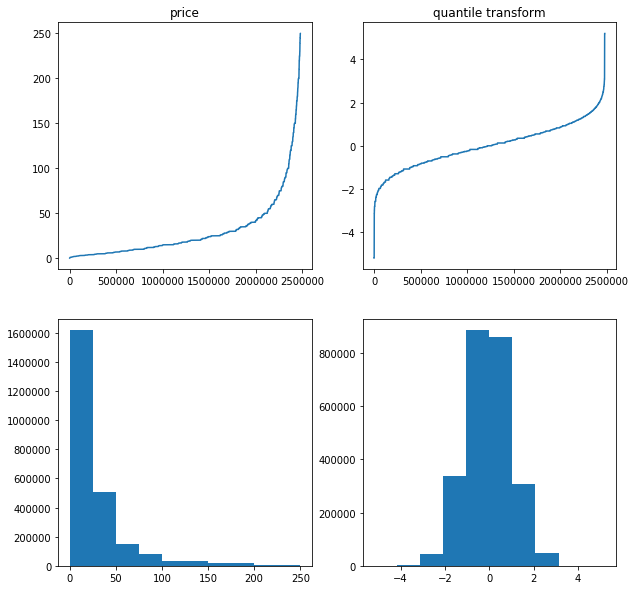

In [18]:
fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax0.plot(sorted(prices))
ax0.set_title('price')
ax2.hist(prices)

ax1.plot(sorted(quantile_prices))
ax1.set_title('quantile transform')
ax3.hist(quantile_prices)

plt.show()

Perform Gradient Boosting Regression

In [25]:
quantile_prices = quantile_prices.reshape(1, -1)

In [30]:
quantile_prices = quantile_prices[0]

In [32]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, quantile_prices, test_size = 0.2, random_state = 0, shuffle=True)
estimator = ensemble.GradientBoostingRegressor(n_estimators=250, max_depth=15, subsample=0.4, random_state=0, verbose=1)
estimator.fit(X_train, y_train)
joblib.dump(estimator, "prices_estimator.pkl")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9535           0.0584          441.68m
         2           0.9015           0.0479          450.46m
         3           0.8602           0.0415          453.92m
         4           0.8263           0.0337          452.29m
         5           0.7969           0.0282          449.53m
         6           0.7688           0.0280          446.53m
         7           0.7442           0.0225          441.69m
         8           0.7250           0.0197          436.28m
         9           0.7102           0.0168          431.48m
        10           0.6928           0.0148          426.87m
        20           0.5932           0.0083          385.82m
        30           0.5388           0.0042          345.52m
        40           0.5053           0.0032          312.18m
        50           0.4836           0.0016          281.91m
        60           0.4663           0.0013          256.63m
       

['prices_estimator.pkl']

In [34]:
predict = estimator.predict(X_test)

In [38]:
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)
explained_variance = explained_variance_score(y_test, predict)
print("MAE: %.4f" % mae)
print("R2: %.4f" % r2)
print("Explained variance: %.4f" % explained_variance)

MAE: 0.4634
R2: 0.6147
Explained variance: 0.6147


array([ 0.27048548, -0.17273102, -0.38032564, ...,  1.18192052,
       -0.07031374, -0.56868553])

In [43]:
real_predicted_prices = quantile_transformer.inverse_transform(predict.reshape(-1,1))

In [44]:
real_y_test = quantile_transformer.inverse_transform(y_test.reshape(-1,1))

In [45]:
mae = mean_absolute_error(real_y_test, real_predicted_prices)
r2 = r2_score(real_y_test, real_predicted_prices)
explained_variance = explained_variance_score(real_y_test, real_predicted_prices)
print("MAE: %.4f" % mae)
print("R2: %.4f" % r2)
print("Explained variance: %.4f" % explained_variance)

MAE: 13.7893
R2: 0.4155
Explained variance: 0.4510


Load views per week

In [46]:
views = joblib.load('../views_250.pkl')

In [52]:
quantile_transformer = QuantileTransformer(output_distribution='normal').fit(views.reshape(-1,1))
quantile_views = quantile_transformer.transform(views.reshape(-1,1))

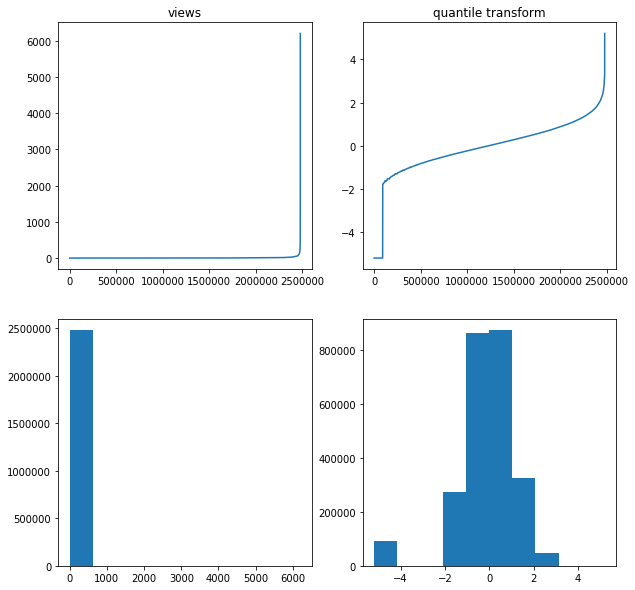

In [53]:
fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax0.plot(sorted(views))
ax0.set_title('views')
ax2.hist(views)

ax1.plot(sorted(quantile_views))
ax1.set_title('quantile transform')
ax3.hist(quantile_views)

plt.show()

In [57]:
quantile_views = quantile_views.reshape(1, -1)

In [58]:
quantile_views = quantile_views[0]

In [63]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, quantile_views, test_size = 0.2, random_state = 0, shuffle=True)
estimator = ensemble.GradientBoostingRegressor(n_estimators=300, max_depth=15, subsample=0.5, random_state=0, verbose=1)
estimator.fit(X_train, y_train)
joblib.dump(estimator, "views_estimator.pkl")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.7711           0.0299          456.25m
         2           1.7489           0.0243          452.18m
         3           1.7270           0.0218          455.91m
         4           1.7089           0.0184          454.94m
         5           1.6891           0.0160          454.43m
         6           1.6754           0.0132          454.36m
         7           1.6611           0.0142          455.55m
         8           1.6506           0.0109          449.25m
         9           1.6427           0.0107          444.79m
        10           1.6258           0.0101          437.52m
        20           1.5495           0.0049          390.23m
        30           1.4938           0.0031          360.50m
        40           1.4577           0.0028          335.05m
        50           1.4226           0.0018          312.89m
        60           1.4088           0.0014          291.49m
       

['views_estimator.pkl']

In [64]:
predict = estimator.predict(X_test)

In [75]:
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)
explained_variance = explained_variance_score(y_test, predict)
print("MAE: %.4f" % mae)
print("R2: %.4f" % r2)
print("Explained variance: %.4f" % explained_variance)

MAE: 0.7624
R2: 0.2807
Explained variance: 0.2807


In [72]:
real_predicted_views = quantile_transformer.inverse_transform(predict.reshape(-1,1))

In [73]:
real_y_test = quantile_transformer.inverse_transform(y_test.reshape(-1,1))

In [74]:
mae = mean_absolute_error(real_y_test, real_predicted_views)
r2 = r2_score(real_y_test, real_predicted_views)
explained_variance = explained_variance_score(real_y_test, real_predicted_views)
print("MAE: %.4f" % mae)
print("R2: %.4f" % r2)
print("Explained variance: %.4f" % explained_variance)

MAE: 4.6304
R2: 0.0062
Explained variance: 0.0331


In [69]:
real_predicted_views = real_predicted_views.reshape(1,-1)[0]

In [70]:
real_y_test = real_y_test.reshape(1,-1)[0]

In [71]:
mae = mean_absolute_error(real_y_test, real_predicted_views)
r2 = r2_score(real_y_test, real_predicted_views)
explained_variance = explained_variance_score(real_y_test, real_predicted_views)
print("MAE: %.4f" % mae)
print("R2: %.4f" % r2)
print("Explained variance: %.4f" % explained_variance)

MAE: 4.6304
R2: 0.0062
Explained variance: 0.0331


In [76]:
joblib.dump([X_train, X_test, y_train, y_test], "views_estimator_test_train_split")

['views_estimator_test_train_split']

In [77]:
joblib.dump(quantile_transformer, "views_quantile_transformer")

['views_quantile_transformer']